<a href="https://colab.research.google.com/github/ArsanyLowise/ObjectDetection_Yolo_v5/blob/main/cityescapes_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kavithak1388/cityscapes")

print("Path to dataset files:", path)

100%|██████████| 11.0G/11.0G [06:39<00:00, 29.6MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kavithak1388/cityscapes/versions/1


In [ ]:
import os

# Path to the extracted dataset
dataset_path = "/root/.cache/kagglehub/datasets/kavithak1388/cityscapes/versions/1"

# List files and directories
print("Dataset folder contents:", os.listdir(dataset_path))


Dataset folder contents: ['Cityscape']


In [ ]:
import shutil

# Destination for the dataset
destination_path = "/content/cityscapes"
shutil.copytree(dataset_path, destination_path, dirs_exist_ok=True)

print("Dataset moved to:", destination_path)
print("Contents of the new dataset path:", os.listdir(destination_path))


Dataset moved to: /content/cityscapes
Contents of the new dataset path: ['Cityscape']


In [ ]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [ ]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=4601734a9ddfdb5a19b76832e4d0d0e91176f36f3068e5e8e3180a5fb96b9de6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=733c071762757a5ba42163046db86e804161c54a2b22f7438c116e9b7109dd21
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
!ls /content/extracted_files
!ls /content/extracted_files/gtFine


ls: cannot access '/content/extracted_files': No such file or directory
ls: cannot access '/content/extracted_files/gtFine': No such file or directory


In [ ]:
dataset = Cityscapes('/content/cityscapes/Cityscape', split='train', mode='fine',
                      target_type='semantic')

In [ ]:
dataset[0][0].size

(2048, 1024)

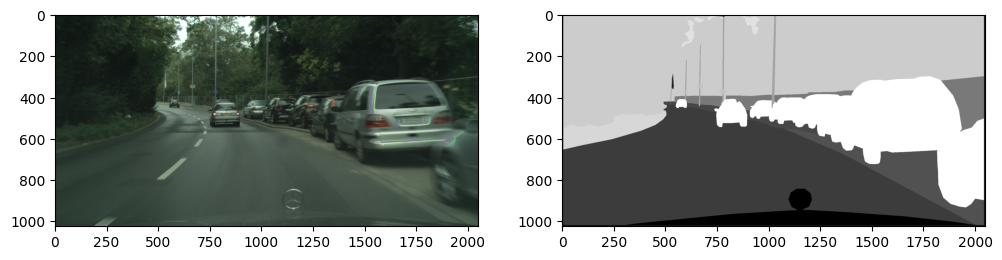

In [ ]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

In [ ]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']
#why i choose 20 classes
#https://stackoverflow.com/a/64242989

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [ ]:
label_mapping = {
    0: 0,  # 'unlabeled'
    1: 1,  # 'road'
    2: 2,  # 'sidewalk'
    3: 3,  # 'building'
    4: 4,  # 'wall'
    5: 5,  # 'fence'
    6: 6,  # 'pole'
    7: 7,  # 'traffic light'
    8: 8,  # 'traffic sign'
    9: 9,  # 'vegetation'
    10: 10, # 'terrain'
    11: 11, # 'sky'
    12: 12, # 'person'
    13: 13, # 'rider'
    14: 14, # 'car'
    15: 15, # 'truck'
    16: 16, # 'bus'
    17: 17, # 'train'
    18: 18, # 'motorcycle'
    19: 19, # 'bicycle'
}


In [ ]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [ ]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [ ]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))
        return transformed['image'],transformed['mask']
    #torch.unsqueeze(transformed['mask'],0)

In [ ]:
dataset=MyClass('/content/cityscapes/Cityscape', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
img,seg= dataset[20]
print(img.shape,seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


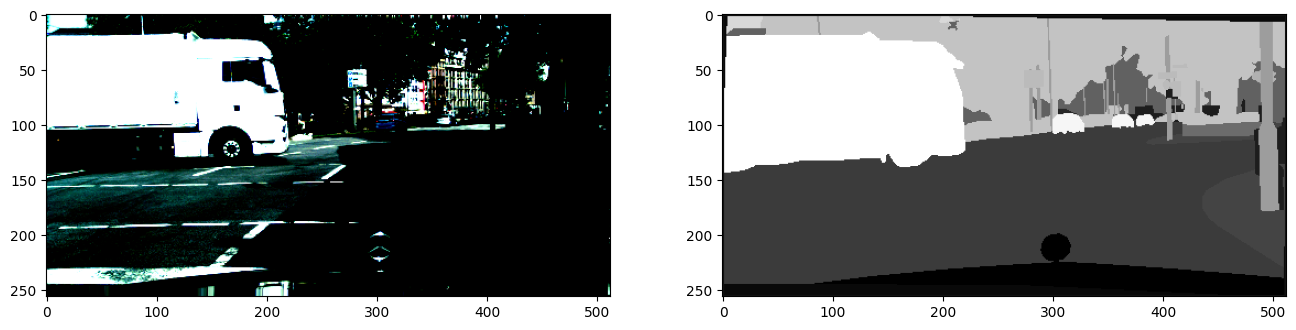

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')

In [ ]:
#class labels before label correction
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 17, 19, 20, 21, 23, 26, 27],
       dtype=torch.uint8)
16


In [ ]:
#class labels after label correction
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 11, 14, 15], dtype=torch.uint8)
12


In [ ]:
#let do coloring
res1=decode_segmap(res.clone())

In [ ]:
import os

label_path = "/content/cityscapes/Cityscape/gtFine/train/aachen"
if not os.path.exists(label_path):
    print("Label path does not exist!")
else:
    print(f"Label path exists: {label_path}")
    # List files to check if they are .png
    label_files = [f for f in os.listdir(label_path) if f.endswith('.png')]
    print(f"Found {len(label_files)} label files.")


Label path exists: /content/cityscapes/Cityscape/gtFine/train/aachen
Found 522 label files.


In [ ]:
import cv2
import os

test_label_file = "/content/cityscapes/Cityscape/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png"
label_image = cv2.imread(test_label_file, cv2.IMREAD_GRAYSCALE)

print("Label Image Shape:", label_image.shape)
unique_values = np.unique(label_image)
print("Unique Label Values in the Image:", unique_values)


Label Image Shape: (1024, 2048)
Unique Label Values in the Image: [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]


In [ ]:
import os
import cv2
import numpy as np

def convert_cityscapes_to_yolo(image_path, label_path, output_path, label_mapping):
    os.makedirs(output_path, exist_ok=True)

    # Map image names to ensure matching
    image_files = {f.split('_leftImg8bit.')[0]: f for f in os.listdir(image_path) if f.endswith('.png')}

    for filename in os.listdir(label_path):
        # Process only label files ending with '_gtFine_labelIds.png'
        if not filename.endswith('_gtFine_labelIds.png'):
            continue

        label_file = os.path.join(label_path, filename)
        label_image = cv2.imread(label_file, cv2.IMREAD_GRAYSCALE)

        # Extract the base name (e.g., "aachen_000012_000019" for Aachen, "berlin_000012_000019" for Berlin, etc.)
        base_name = filename.replace('_gtFine_labelIds.png', '')

        if base_name not in image_files:
            print(f"Warning: No matching image found for label file {filename}")
            continue

        image_filename = image_files[base_name]
        output_label_file = os.path.join(output_path, image_filename.replace('.png', '.txt'))

        h, w = label_image.shape
        yolo_annotations = []

        # Iterate through each class ID in the mapping
        for class_value, class_id in label_mapping.items():
            mask = (label_image == class_value).astype(np.uint8)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Get bounding boxes for each object in the image
            for contour in contours:
                x, y, box_w, box_h = cv2.boundingRect(contour)
                if box_w > 0 and box_h > 0:  # Only include non-zero bounding boxes
                    x_center = (x + box_w / 2) / w
                    y_center = (y + box_h / 2) / h
                    norm_width = box_w / w
                    norm_height = box_h / h
                    yolo_annotations.append(f"{class_id} {x_center} {y_center} {norm_width} {norm_height}")

        # Save YOLO annotation file if there are any annotations
        if yolo_annotations:
            with open(output_label_file, 'w') as f:
                f.write('\n'.join(yolo_annotations))
            print(f"Saved: {output_label_file}")

# Example label mapping
label_mapping = {
    0: 0,  # road
    1: 1,  # sidewalk
    2: 2,  # building
    3: 3,  # wall
    4: 4,  # fence
    5: 5,  # vegetation
    6: 6,  # terrain
    7: 7,  # sky
    8: 8,  # person
    9: 9,  # rider
    10: 10, # car
    11: 11, # truck
    12: 12, # bus
    13: 13, # train
    14: 14, # motorcycle
    15: 15, # bicycle
    16: 16, # other
}

# Paths for Aachen, Berlin, and Frankfurt
image_paths = {
    "aachen_train": "/content/cityscapes/Cityscape/leftImg8bit/train/aachen",
    "berlin_train": "/content/cityscapes/Cityscape/leftImg8bit/test/berlin",
    "frankfurt_val": "/content/cityscapes/Cityscape/leftImg8bit/val/frankfurt"
}

label_paths = {
    "aachen_train": "/content/cityscapes/Cityscape/gtFine/train/aachen",
    "berlin_train": "/content/cityscapes/Cityscape/gtFine/test/berlin",
    "frankfurt_val": "/content/cityscapes/Cityscape/gtFine/val/frankfurt"
}

output_paths = {
    "aachen_train": "/content/cityscapes/Cityscape/leftImg8bit/train/aachen",
    "berlin_train": "/content/cityscapes/Cityscape/leftImg8bit/test/berlin",
    "frankfurt_val": "/content/cityscapes/Cityscape/leftImg8bit/val/frankfurt"
}

# Convert labels for Aachen train
convert_cityscapes_to_yolo(image_paths["aachen_train"], label_paths["aachen_train"], output_paths["aachen_train"], label_mapping)

# Convert labels for Berlin train
convert_cityscapes_to_yolo(image_paths["berlin_train"], label_paths["berlin_train"], output_paths["berlin_train"], label_mapping)

# Convert labels for Frankfurt validation
convert_cityscapes_to_yolo(image_paths["frankfurt_val"], label_paths["frankfurt_val"], output_paths["frankfurt_val"], label_mapping)


Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000080_000019_leftImg8bit.txt
Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000168_000019_leftImg8bit.txt
Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000043_000019_leftImg8bit.txt
Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000017_000019_leftImg8bit.txt
Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000115_000019_leftImg8bit.txt
Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000153_000019_leftImg8bit.txt
Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000070_000019_leftImg8bit.txt
Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000044_000019_leftImg8bit.txt
Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000012_000019_leftImg8bit.txt
Saved: /content/cityscapes/Cityscape/leftImg8bit/train/aachen/aachen_000088_000019_leftImg8bit.txt
Saved: /co

In [ ]:
yaml_content = """
# Train/val/test sets as 1) dir: /content/cityscapes/Cityscape/labels/train/aachen, 2) file: /content/cityscapes/Cityscape/labels/val/frankfurt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: /content/cityscapes/Cityscape  # dataset root dir
train: /content/cityscapes/Cityscape/leftImg8bit/train/aachen  # train images (relative to 'path')
val: /content/cityscapes/Cityscape/leftImg8bit/val/frankfurt  # val images (relative to 'path')
test: /content/cityscapes/Cityscape/leftImg8bit/test/berlin  # test images (optional)

# Classes
nc: 19  # Number of classes
names:  # Class names
  - road
  - sidewalk
  - building
  - wall
  - fence
  - vegetation
  - terrain
  - sky
  - person
  - rider
  - car
  - truck
  - bus
  - train
  - motorcycle
  - bicycle
  - other
  - background
  """

# Save the YAML content to a file
yaml_file_path = "/content/cityscapes/Cityscape/cityscapes.yaml"
with open(yaml_file_path, 'w') as f:
    f.write(yaml_content)


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17075, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 17075 (delta 29), reused 30 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17075/17075), 15.69 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (11723/11723), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 37.6 MB/s eta 0:00:00


In [ ]:
!python train.py --img 512 --batch 16 --epochs 2 --data /content/cityscapes/Cityscape/cityscapes.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --save-period 1


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-16 15:40:31.465255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 15:40:31.509840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 15:40:31.521274: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi